In [2]:
import json
import pandas as pd
import matplotlib as plt

In [24]:
import json
import pandas as pd

# Charger le fichier COCO
with open("../data/_annotations.coco.json", "r") as f:
    coco_data = json.load(f)

# Transformer en DataFrames
images_df = pd.DataFrame(coco_data["images"])
annotations_df = pd.DataFrame(coco_data["annotations"])
categories_df = pd.DataFrame(coco_data["categories"])

print("Images :", images_df.shape)
print("Annotations :", annotations_df.shape)
print("Catégories :", categories_df.shape)

print("\nAperçu des images :")
print(images_df.head())

print("\nAperçu des annotations :")
print(annotations_df.head())

print("\nAperçu des catégories :")
print(categories_df.head())


Images : (500, 7)
Annotations : (959, 7)
Catégories : (2, 3)

Aperçu des images :
   id  license                                          file_name  height  \
0   0        1  cl6e1qges001kgk555z158f33_2_FALSE_COLOR_jpg.rf...     860   
1   1        1  cl6kgm9qr002yc455g5qs87kz_2_FALSE_COLOR_jpg.rf...     860   
2   2        1  cl6odzs5e002oao55heuig0a6_1_TRUE_COLOR_jpg.rf....     860   
3   3        1  cl6b6pieh007rl455fwvb73gr_1_TRUE_COLOR_jpg.rf....     860   
4   4        1  cl6b5k38g003zl455bgtd1317_4_FALSE_COLOR__URBAN...     860   

   width              date_captured  \
0   1200  2025-09-14T12:06:19+00:00   
1   1200  2025-09-14T12:06:19+00:00   
2   1200  2025-09-14T12:06:19+00:00   
3   1200  2025-09-14T12:06:19+00:00   
4   1200  2025-09-14T12:06:19+00:00   

                                               extra  
0  {'name': 'cl6e1qges001kgk555z158f33_2_FALSE_CO...  
1  {'name': 'cl6kgm9qr002yc455g5qs87kz_2_FALSE_CO...  
2  {'name': 'cl6odzs5e002oao55heuig0a6_1_TRUE_COL...  


In [29]:
import pandas as pd

def check_invalid_categories(annotations_df: pd.DataFrame, categories_df: pd.DataFrame) -> pd.DataFrame:
    """Annotations avec category_id qui n'existe pas dans categories_df."""
    valid_ids = categories_df['id'].unique()
    return annotations_df[~annotations_df['category_id'].isin(valid_ids)]

def check_invalid_images(annotations_df: pd.DataFrame, images_df: pd.DataFrame) -> pd.DataFrame:
    """Annotations avec image_id qui n'existe pas dans images_df."""
    valid_ids = images_df['id'].unique()
    return annotations_df[~annotations_df['image_id'].isin(valid_ids)]

def check_bbox(annotations_df: pd.DataFrame, images_df: pd.DataFrame) -> pd.DataFrame:
    """BBoxes qui sortent des dimensions de l'image."""
    merged = annotations_df.merge(images_df, left_on='image_id', right_on='id', suffixes=('_ann', '_img'))
    invalid = merged[
        (merged['bbox'].apply(lambda x: x[0] < 0 or x[1] < 0)) | # x_min, y_min négatifs
        (merged.apply(lambda r: r['bbox'][0] + r['bbox'][2] > r['width'], axis=1)) | # x+w > largeur image
        (merged.apply(lambda r: r['bbox'][1] + r['bbox'][3] > r['height'], axis=1))  # y+h > hauteur image
    ]
    return invalid

def check_zero_area(annotations_df: pd.DataFrame) -> pd.DataFrame:
    """BBoxes avec largeur ou hauteur nulle."""
    invalid = annotations_df[
        annotations_df['bbox'].apply(lambda x: x[2] == 0 or x[3] == 0)
    ]
    return invalid

print("\n--- Vérification des données ---\n")

invalid_categories = check_invalid_categories(annotations_df, categories_df)
print("Annotations avec catégories invalides :", len(invalid_categories))

invalid_images = check_invalid_images(annotations_df, images_df)
print("Annotations avec images invalides :", len(invalid_images))

invalid_bboxes = check_bbox(annotations_df, images_df)
print("BBoxes hors limites :", len(invalid_bboxes))

zero_area = check_zero_area(annotations_df)
print("BBoxes surface :" , len(zero_area))
      


      



--- Vérification des données ---

Annotations avec catégories invalides : 0
Annotations avec images invalides : 0
BBoxes hors limites : 44
BBoxes surface : 0


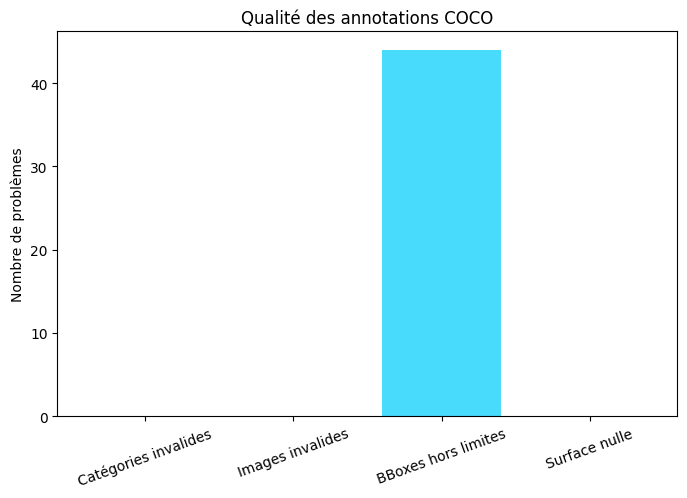

In [30]:
import matplotlib.pyplot as plt

# Comptages
counts = {
    "Catégories invalides": len(invalid_categories),
    "Images invalides": len(invalid_images),
    "BBoxes hors limites": len(invalid_bboxes),
    "Surface nulle": len(zero_area)
}

# Création du graphique
plt.figure(figsize=(8, 5))
plt.bar(counts.keys(), counts.values(), color=["#ff6b6b", "#feca57", "#48dbfb", "#1dd1a1"])
plt.title("Qualité des annotations COCO")
plt.ylabel("Nombre de problèmes")
plt.xticks(rotation=20)
plt.show()
